In [19]:
import os
import pathlib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import shutil
import random
import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D, Activation, GlobalMaxPool2D, BatchNormalization
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras import Input, Model
from tensorflow.keras.utils import plot_model
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import splitfolders

In [20]:
# splits dataset it into three subfolders: train, val (validation), and test.

splitfolders.ratio(r"C:\Users\Ajay\Desktop\currency-note-classification-V2\Dataset", output="output",
    seed=1337, ratio=(.75, .2, .05), group_prefix=None, move=False)

In [21]:
data_dir = pathlib.Path('output/')
train_dir = 'output/train'
val_dir = 'output/val'
test_dir = 'output/test'

In [22]:
class_name = np.array(sorted([item.name for item in data_dir.glob("*")]))
print(class_name)

['test' 'train' 'val']


In [23]:
for dirpath, dirnames, filenames in os.walk('output'):
  print(f"{len(dirnames)} folder and {len(filenames)} images in {dirpath}")

3 folder and 0 images in output
6 folder and 0 images in output\test
0 folder and 23 images in output\test\10
0 folder and 23 images in output\test\100
0 folder and 23 images in output\test\20
0 folder and 25 images in output\test\200
0 folder and 23 images in output\test\50
0 folder and 23 images in output\test\500
6 folder and 0 images in output\train
0 folder and 336 images in output\train\10
0 folder and 337 images in output\train\100
0 folder and 337 images in output\train\20
0 folder and 375 images in output\train\200
0 folder and 337 images in output\train\50
0 folder and 327 images in output\train\500
6 folder and 0 images in output\val
0 folder and 89 images in output\val\10
0 folder and 90 images in output\val\100
0 folder and 90 images in output\val\20
0 folder and 100 images in output\val\200
0 folder and 90 images in output\val\50
0 folder and 87 images in output\val\500


In [24]:
def view_random_image(target_dir, target_class):
    target_folder = target_dir + target_class
    random_image = random.sample(os.listdir(target_folder), 1)
    img = mpimg.imread(target_folder + "/" + random_image[0])
    plt.imshow(img)
    plt.title(target_class)
    plt.axis("off")
    
    print(f"Image Shape : {img.shape}")
    plt.show()

Image Shape : (188, 473, 3)


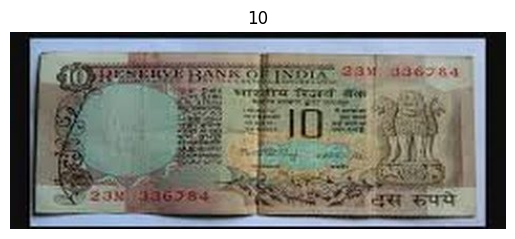

In [25]:
for i in range(1,2):
    img_n = view_random_image(target_dir='output/train/', target_class='10')

In [26]:
# Sets the global random seed.
tf.random.set_seed(46)

# preprocess data
train_datagen = ImageDataGenerator(rescale=1/255.0,
                                   rotation_range=0.2,
                                   zoom_range=0.2,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   vertical_flip=True,
                                   horizontal_flip=True)
valid_datagen = ImageDataGenerator(rescale=1/255.0)
test_datagen = ImageDataGenerator(rescale=1/255.0)

In [27]:
train_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size=64,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               shuffle=True,
                                               seed=46)

valid_data = valid_datagen.flow_from_directory(val_dir,
                                               batch_size=64,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               shuffle=False,
                                               seed=46)

test_data = test_datagen.flow_from_directory(test_dir,
                                               batch_size=64,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               shuffle=False,
                                               seed=46)

Found 2049 images belonging to 6 classes.
Found 546 images belonging to 6 classes.
Found 140 images belonging to 6 classes.


In [28]:
train_data.class_indices

{'10': 0, '100': 1, '20': 2, '200': 3, '50': 4, '500': 5}

In [29]:
train_y=train_data.classes
val_y=valid_data.classes
test_y=test_data.classes

In [30]:
print("train_y.shape: ", train_y.shape)
print("val_y.shape: ", val_y.shape)
print("test_y.shape: ", test_y.shape)

train_y.shape:  (2049,)
val_y.shape:  (546,)
test_y.shape:  (140,)


In [31]:
base_model = tf.keras.applications.DenseNet121(input_shape=(224, 224, 3),
                                                        include_top=False,
                                                        weights='imagenet')
base_model.trainable = False

In [32]:
global_average_layer = GlobalAveragePooling2D()
prediction_layer = Dense(6)
softmax = Activation('softmax')

inputs = Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = Dropout(0.25)(x)
x = global_average_layer(x)
outputs = prediction_layer(x)
outputs = softmax(outputs)

model = Model(inputs, outputs)

In [33]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         6,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 6)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,043,654 (26.87 MB)

 Trainable params: 6,150 (24.02 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [34]:
plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [35]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])

# train model
history = model.fit(train_data, epochs=50, validation_data=valid_data)

Epoch 1/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 251s 7s/step - accuracy: 0.1887 - loss: 1.9834 - val_accuracy: 0.3114 - val_loss: 1.7295
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 222s 7s/step - accuracy: 0.3641 - loss: 1.5928 - val_accuracy: 0.4744 - val_loss: 1.4843
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 185s 6s/step - accuracy: 0.4942 - loss: 1.4096 - val_accuracy: 0.5366 - val_loss: 1.3148
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 176s 5s/step - accuracy: 0.5589 - loss: 1.2467 - val_accuracy: 0.5733 - val_loss: 1.1962
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 175s 5s/step - accuracy: 0.6015 - loss: 1.1495 - val_accuracy: 0.5897 - val_loss: 1.1001
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 174s 5s/step - accuracy: 0.6392 - loss: 1.0629 - val_accuracy: 0.6484 - val_loss: 1.0410
Epoch 7/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 174s 5s/step - accuracy: 0.6242 - loss: 1.0502 - val_accuracy: 0.6374 - val_loss: 0.9886
Epoch 8/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 181s 5s/step - accuracy: 0.6968 - loss: 0.9465 - val_accuracy: 0.6832 - v

In [36]:
model.save('my_model.keras')

In [37]:
def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(loss))

  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title("Loss Curves")
  plt.xlabel("Epochs")
  plt.legend()

  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title("Accuracy Curves")
  plt.xlabel("Epochs")
  plt.legend()

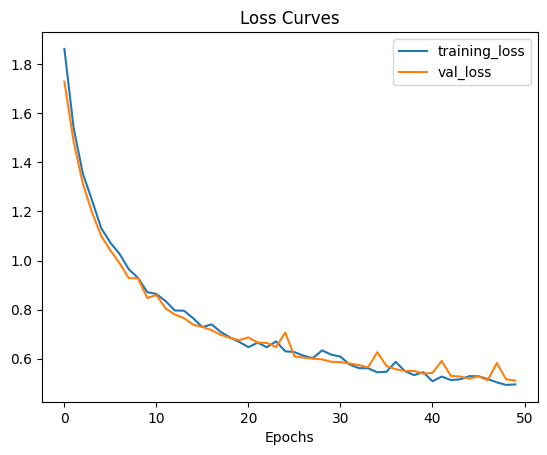

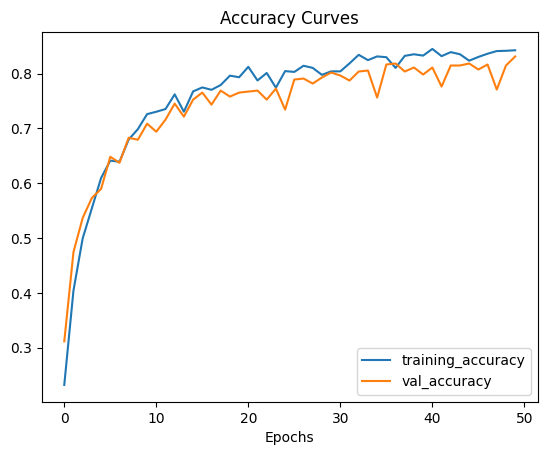

In [38]:
plot_loss_curves(history)

In [39]:
val_pred = model.predict(valid_data)
val_pred = val_pred.argmax(axis=1)
print(classification_report(val_pred, val_y))

9/9 ━━━━━━━━━━━━━━━━━━━━ 47s 5s/step 
              precision    recall  f1-score   support

           0       0.75      0.84      0.79        80
           1       0.87      0.76      0.81       102
           2       0.92      0.83      0.87       100
           3       0.88      0.92      0.90        96
           4       0.62      0.72      0.67        78
           5       0.94      0.91      0.93        90

    accuracy                           0.83       546
   macro avg       0.83      0.83      0.83       546
weighted avg       0.84      0.83      0.83       546



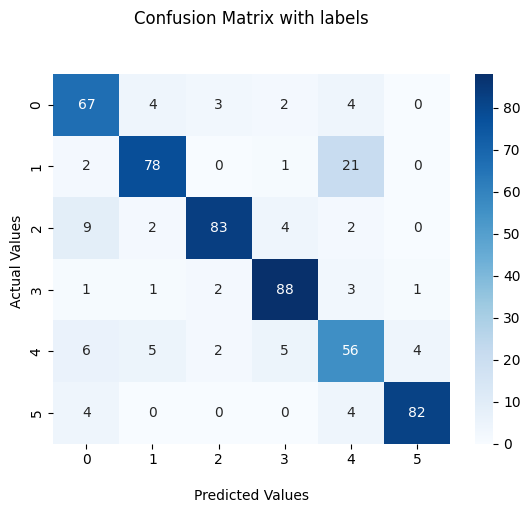

In [40]:
cfm_val = confusion_matrix(val_pred, val_y)
ax = sns.heatmap(cfm_val, annot=True, 
            cmap='Blues')

# Preparation for plotting confusion matrix
ax.set_title('Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

# Display the visualization of the Confusion Matrix.
plt.show()

In [41]:
test_pred = model.predict(test_data)
test_pred = test_pred.argmax(axis=1)
print(classification_report(test_pred, test_y))

C:\Users\Ajay\anaconda3\envs\ai\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step
              precision    recall  f1-score   support

           0       0.70      0.84      0.76        19
           1       0.87      0.69      0.77        29
           2       0.74      0.81      0.77        21
           3       1.00      0.86      0.93        29
           4       0.65      0.83      0.73        18
           5       1.00      0.96      0.98        24

    accuracy                           0.83       140
   macro avg       0.83      0.83      0.82       140
weighted avg       0.85      0.83      0.83       140



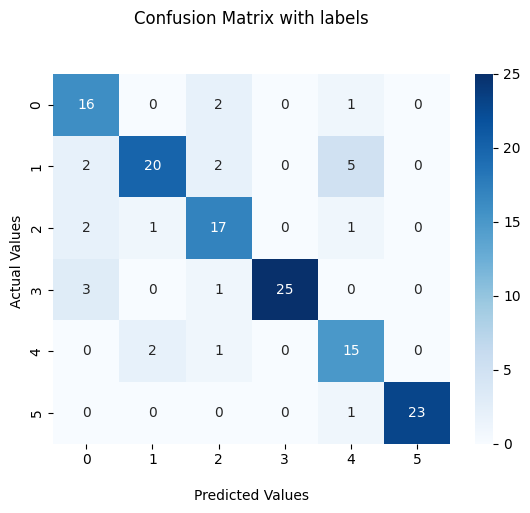

In [42]:
cfm_test = confusion_matrix(test_pred, test_y)
ax = sns.heatmap(cfm_test, annot=True, 
            cmap='Blues')

# Preparation for plotting confusion matrix
ax.set_title('Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

# Display the visualization of the Confusion Matrix.
plt.show()

In [43]:
!pip install opencv-python

   ---------------------------------------- 0.0/39.5 MB ? eta -:--:--
   -- ------------------------------------- 2.4/39.5 MB 11.2 MB/s eta 0:00:04
   ----- ---------------------------------- 5.0/39.5 MB 11.6 MB/s eta 0:00:03
   ------- -------------------------------- 7.1/39.5 MB 11.5 MB/s eta 0:00:03
   --------- ------------------------------ 9.4/39.5 MB 11.3 MB/s eta 0:00:03
   ----------- ---------------------------- 11.8/39.5 MB 11.4 MB/s eta 0:00:03
   -------------- ------------------------- 14.2/39.5 MB 11.4 MB/s eta 0:00:03
   ---------------- ----------------------- 16.5/39.5 MB 11.4 MB/s eta 0:00:03
   ------------------- -------------------- 18.9/39.5 MB 11.5 MB/s eta 0:00:02
   --------------------- ------------------ 21.2/39.5 MB 11.5 MB/s eta 0:00:02
   ----------------------- ---------------- 23.6/39.5 MB 11.4 MB/s eta 0:00:02
   -------------------------- ------------- 26.0/39.5 MB 11.3 MB/s eta 0:00:02
   ---------------------------- ----------- 28.0/39.5 MB 11.3 MB/

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
You have a 200 rupees note.


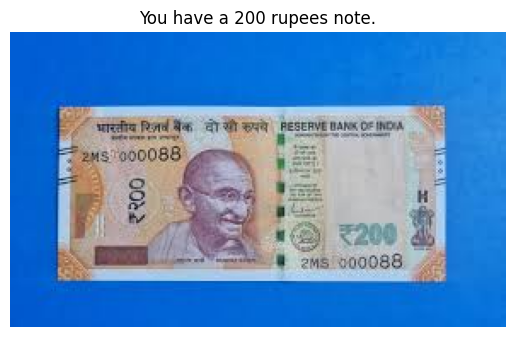

In [61]:
import matplotlib.pyplot as plt
from keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np

# Load the trained model
model = load_model('my_model.keras')

# Define class-specific messages
class_messages = {
    0: "You have a 10 rupees note.",
    1: "You have a 100 rupees note.",
    2: "You have a 20 rupees note.",
    3: "You have a 200 rupees note.",
    4: "You have a 50 rupees note.",
    5: "You have a 500 rupees note."
}

# Load the image for prediction
image_path = r"C:\Users\Ajay\Downloads\images.jpeg"

img = image.load_img(image_path, target_size=(224, 224))

# Preprocess the image
img = image.img_to_array(img)  # Convert the image to a NumPy array
img = img / 255.0  # Normalize the image
img = np.expand_dims(img, axis=0)  # Add a batch dimension

# Predict the label
label = model.predict(img)

# Determine the predicted class
predicted_class_index = np.argmax(label)
predicted_message = class_messages[predicted_class_index]

# Print the customized message
print(predicted_message)

# Display the image with the predicted label
plt.imshow(image.load_img(image_path))
plt.title(predicted_message)
plt.axis('off')
plt.show()


In [ ]:
import cv2
import numpy as np
from keras.models import load_model

# Load the trained model
model = load_model('my_model.keras')

# Define class-specific messages
class_messages = {
    0: "You have a 10 rupees note.",
    1: "You have a 100 rupees note.",
    2: "You have a 20 rupees note.",
    3: "You have a 200 rupees note.",
    4: "You have a 50 rupees note.",
    5: "You have a 500 rupees note."
}


# Function to preprocess the image for prediction
def preprocess_frame(frame):
    frame_resized = cv2.resize(frame, (224, 224))  # Resize to model input size
    frame_array = np.array(frame_resized, dtype="float32") / 255.0  # Normalize
    frame_array = np.expand_dims(frame_array, axis=0)  # Add batch dimension
    return frame_array

# Access the webcam
cap = cv2.VideoCapture(0)

if not cap.isOpened():
    print("Error: Could not access the webcam.")
else:
    print("Press 'q' to quit the application.")

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        print("Failed to grab frame. Exiting...")
        break

    # Get frame dimensions
    height, width, _ = frame.shape

    # Define ROI coordinates (center rectangle)
    roi_x1 = int(width * 0.3)
    roi_y1 = int(height * 0.3)
    roi_x2 = int(width * 0.7)
    roi_y2 = int(height * 0.7)

    # Draw rectangle on the frame
    cv2.rectangle(frame, (roi_x1, roi_y1), (roi_x2, roi_y2), (0, 255, 0), 2)

    # Extract the ROI for prediction
    roi = frame[roi_y1:roi_y2, roi_x1:roi_x2]

    # Preprocess the ROI
    preprocessed_roi = preprocess_frame(roi)

    # Predict the currency note
    predictions = model.predict(preprocessed_roi)
    predicted_class_index = np.argmax(predictions)
    predicted_message = class_messages[predicted_class_index]

    # Display the result on the webcam feed
    cv2.putText(
        frame,
        predicted_message,
        (10, 30),
        cv2.FONT_HERSHEY_SIMPLEX,
        1,
        (0, 255, 0),
        2
    )
    cv2.imshow("Currency Note Detection", frame)

    # Press 'q' to exit
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the webcam and close all OpenCV windows
cap.release()
cv2.destroyAllWindows()


Press 'q' to quit the application.
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169m

In [62]:
import cv2
import numpy as np
from keras.models import load_model
from tensorflow.keras.preprocessing import image
import time

def main():
    # Load the trained model
    model = load_model('my_model.keras')
    
    # Define class-specific messages
    class_messages = {
        0: "10 Rupees Note",
        1: "100 Rupees Note",
        2: "20 Rupees Note",
        3: "200 Rupees Note",
        4: "50 Rupees Note",
        5: "500 Rupees Note"
    }
    
    # Initialize camera
    cap = cv2.VideoCapture(0)  # Use 0 for default camera
    
    # Set camera resolution
    cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)
    cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)
    
    # Initialize variables for prediction timing
    last_prediction_time = 0
    prediction_interval = 0.5  # Make prediction every 0.5 seconds
    current_message = "Please show a currency note"
    
    while True:
        # Read frame from camera
        ret, frame = cap.read()
        if not ret:
            print("Failed to grab frame")
            break
            
        # Get current time
        current_time = time.time()
        
        # Make prediction every 'prediction_interval' seconds
        if current_time - last_prediction_time >= prediction_interval:
            # Preprocess the frame
            # Convert BGR to RGB
            rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            
            # Resize to match model's expected input size
            resized_frame = cv2.resize(rgb_frame, (224, 224))
            
            # Convert to array and normalize
            img_array = image.img_to_array(resized_frame)
            img_array = img_array / 255.0
            img_array = np.expand_dims(img_array, axis=0)
            
            # Make prediction
            prediction = model.predict(img_array, verbose=0)
            confidence = np.max(prediction)
            
            # Only update message if confidence is high enough
            if confidence > 0.7:  # Adjust threshold as needed
                predicted_class = np.argmax(prediction)
                current_message = class_messages.get(predicted_class, "Unknown Note")
            else:
                current_message = "Please show a currency note clearly"
                
            last_prediction_time = current_time
        
        # Add text to frame
        # Calculate text size for centering
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 1.5
        thickness = 3
        text_size = cv2.getTextSize(current_message, font, font_scale, thickness)[0]
        text_x = (frame.shape[1] - text_size[0]) // 2
        text_y = 50
        
        # Add background rectangle for text
        cv2.rectangle(frame, 
                     (text_x - 10, text_y - text_size[1] - 10),
                     (text_x + text_size[0] + 10, text_y + 10),
                     (0, 0, 0),
                     -1)
        
        # Add text
        cv2.putText(frame,
                    current_message,
                    (text_x, text_y),
                    font,
                    font_scale,
                    (255, 255, 255),
                    thickness)
        
        # Display the frame
        cv2.imshow('Currency Detection', frame)
        
        # Break loop on 'q' press
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    
    # Release resources
    cap.release()
    cv2.destroyAllWindows()

if __name__ == "__main__":
    main()

In [63]:
import cv2
import numpy as np
from keras.models import load_model
from tensorflow.keras.preprocessing import image
import time

def main():
    # Load the trained model
    model = load_model('my_model.keras')
    
    # Define class-specific messages
    class_messages = {
        0: "10 Rupees Note",
        1: "100 Rupees Note",
        2: "20 Rupees Note",
        3: "200 Rupees Note",
        4: "50 Rupees Note",
        5: "500 Rupees Note"
    }
    
    # Initialize camera
    cap = cv2.VideoCapture(0)  # Use 0 for default camera
    
    # Set camera resolution
    cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)
    cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)
    
    # Initialize variables for prediction timing
    last_prediction_time = 0
    prediction_interval = 0.5  # Make prediction every 0.5 seconds
    current_message = "Please place the note inside the box"
    
    while True:
        # Read frame from camera
        ret, frame = cap.read()
        if not ret:
            print("Failed to grab frame")
            break
            
        # Get current time
        current_time = time.time()
        
        # Define rectangle box dimensions
        frame_height, frame_width = frame.shape[:2]
        box_width = int(frame_width * 0.6)  # 60% of frame width
        box_height = int(frame_height * 0.4)  # 40% of frame height
        box_x = (frame_width - box_width) // 2
        box_y = (frame_height - box_height) // 2
        
        # Draw rectangle box
        cv2.rectangle(frame,
                     (box_x, box_y),
                     (box_x + box_width, box_y + box_height),
                     (0, 255, 0),  # Green color
                     3)  # Thickness
        
        # Make prediction every 'prediction_interval' seconds
        if current_time - last_prediction_time >= prediction_interval:
            # Crop the frame to the box area
            roi = frame[box_y:box_y + box_height, box_x:box_x + box_width]
            
            # Preprocess the cropped frame
            rgb_roi = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
            resized_roi = cv2.resize(rgb_roi, (224, 224))
            img_array = image.img_to_array(resized_roi)
            img_array = img_array / 255.0
            img_array = np.expand_dims(img_array, axis=0)
            
            # Make prediction
            prediction = model.predict(img_array, verbose=0)
            confidence = np.max(prediction)
            
            # Only update message if confidence is high enough
            if confidence > 0.7:  # Adjust threshold as needed
                predicted_class = np.argmax(prediction)
                current_message = class_messages.get(predicted_class, "Unknown Note")
            else:
                current_message = "Please place the note inside the box clearly"
                
            last_prediction_time = current_time
        
        # Add text to frame
        # Calculate text size for centering
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 1.5
        thickness = 3
        text_size = cv2.getTextSize(current_message, font, font_scale, thickness)[0]
        text_x = (frame.shape[1] - text_size[0]) // 2
        text_y = 50
        
        # Add background rectangle for text
        cv2.rectangle(frame, 
                     (text_x - 10, text_y - text_size[1] - 10),
                     (text_x + text_size[0] + 10, text_y + 10),
                     (0, 0, 0),
                     -1)
        
        # Add text
        cv2.putText(frame,
                    current_message,
                    (text_x, text_y),
                    font,
                    font_scale,
                    (255, 255, 255),
                    thickness)
        
        # Display the frame
        cv2.imshow('Currency Detection', frame)
        
        # Break loop on 'q' press
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    
    # Release resources
    cap.release()
    cv2.destroyAllWindows()

if __name__ == "__main__":
    main()

In [66]:
import cv2
import numpy as np
from keras.models import load_model
from tensorflow.keras.preprocessing import image
import time
import pyttsx3

def main():
    # Initialize text-to-speech engine
    engine = pyttsx3.init()
    
    # Set properties (optional)
    engine.setProperty('rate', 150)    # Speed of speech
    engine.setProperty('volume', 0.9)  # Volume (0.0 to 1.0)
    
    # Load the trained model
    model = load_model('my_model.keras')
    
    # Define class-specific messages
    class_messages = {
        0: "10 Rupees Note",
        1: "100 Rupees Note",
        2: "20 Rupees Note",
        3: "200 Rupees Note",
        4: "50 Rupees Note",
        5: "500 Rupees Note"
    }
    
    # Initialize camera
    cap = cv2.VideoCapture(0)  # Use 0 for default camera
    
    # Set camera resolution
    cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)
    cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)
    
    # Initialize variables for prediction timing
    last_prediction_time = 0
    prediction_interval = 0.5  # Make prediction every 0.5 seconds
    current_message = "Please place the note inside the box"
    last_spoken_message = ""
    
    while True:
        # Read frame from camera
        ret, frame = cap.read()
        if not ret:
            print("Failed to grab frame")
            break
            
        # Get current time
        current_time = time.time()
        
        # Define rectangle box dimensions
        frame_height, frame_width = frame.shape[:2]
        box_width = int(frame_width * 0.6)  # 60% of frame width
        box_height = int(frame_height * 0.4)  # 40% of frame height
        box_x = (frame_width - box_width) // 2
        box_y = (frame_height - box_height) // 2
        
        # Draw rectangle box
        cv2.rectangle(frame,
                     (box_x, box_y),
                     (box_x + box_width, box_y + box_height),
                     (0, 255, 0),  # Green color
                     3)  # Thickness
        
        # Make prediction every 'prediction_interval' seconds
        if current_time - last_prediction_time >= prediction_interval:
            # Crop the frame to the box area
            roi = frame[box_y:box_y + box_height, box_x:box_x + box_width]
            
            # Preprocess the cropped frame
            rgb_roi = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
            resized_roi = cv2.resize(rgb_roi, (224, 224))
            img_array = image.img_to_array(resized_roi)
            img_array = img_array / 255.0
            img_array = np.expand_dims(img_array, axis=0)
            
            # Make prediction
            prediction = model.predict(img_array, verbose=0)
            confidence = np.max(prediction)
            
            # Only update message if confidence is high enough
            if confidence > 0.7:  # Adjust threshold as needed
                predicted_class = np.argmax(prediction)
                current_message = class_messages.get(predicted_class, "Unknown Note")
                
                # Speak the message only if it's different from the last spoken message
                if current_message != last_spoken_message:
                    engine.say(current_message)
                    engine.runAndWait()
                    last_spoken_message = current_message
            else:
                current_message = "Please place the note inside the box clearly"
                # Reset last spoken message when no note is detected
                last_spoken_message = ""
                
            last_prediction_time = current_time
        
        # Add text to frame
        # Calculate text size for centering
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 1.5
        thickness = 3
        text_size = cv2.getTextSize(current_message, font, font_scale, thickness)[0]
        text_x = (frame.shape[1] - text_size[0]) // 2
        text_y = 50
        
        # Add background rectangle for text
        cv2.rectangle(frame, 
                     (text_x - 10, text_y - text_size[1] - 10),
                     (text_x + text_size[0] + 10, text_y + 10),
                     (0, 0, 0),
                     -1)
        
        # Add text
        cv2.putText(frame,
                    current_message,
                    (text_x, text_y),
                    font,
                    font_scale,
                    (255, 255, 255),
                    thickness)
        
        # Display the frame
        cv2.imshow('Currency Detection', frame)
        
        # Break loop on 'q' press
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    
    # Release resources
    cap.release()
    cv2.destroyAllWindows()
    engine.stop()

if __name__ == "__main__":
    main()

In [65]:
pip install pyttsx3

  Using cached pyttsx3-2.98-py3-none-any.whl.metadata (3.8 kB)
  Using cached pypiwin32-223-py3-none-any.whl.metadata (236 bytes)
Using cached pyttsx3-2.98-py3-none-any.whl (34 kB)
Using cached pypiwin32-223-py3-none-any.whl (1.7 kB)
Note: you may need to restart the kernel to use updated packages.
